# Model Training Notebook

This notebook contains the model training process for our fruit classification task.

In [11]:
import os
import cv2
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

## Step 1: Setup Configuration

In [12]:
# Directory Setup
BASE_DIR = "/home/heangchihav/Documents/NMU/MachineLearning/machine_learning"
DATADIR = os.path.join(BASE_DIR, "data/preprocessed/train")
MODEL_DIR = os.path.join(BASE_DIR, "models")  # For .h5 model file
PROCESSED_DIR = os.path.join(BASE_DIR, "data/processed_arrays")  # For pickle files

CATEGORIES = ["grape", "apple"]
IMG_SIZE = 50

# Create necessary directories
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

## Step 2: Create Training Data

In [13]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                print(f"Error processing {img}: {e}")
                pass

create_training_data()
print(f"Total training samples: {len(training_data)}")

Total training samples: 1788


## Step 3: Prepare Features and Labels

In [14]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert to NumPy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Add channel dimension
y = np.array(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1788, 50, 50, 1)
y shape: (1788,)


## Step 4: Save Data to Pickle (in processed_arrays directory)

In [15]:
# Save features
with open(os.path.join(PROCESSED_DIR, "X.pickle"), "wb") as file:
    pickle.dump(X, file)

# Save labels
with open(os.path.join(PROCESSED_DIR, "y.pickle"), "wb") as file:
    pickle.dump(y, file)

# Verify pickle files were created
print("\nVerifying pickle files:")
print(f"X.pickle exists: {os.path.exists(os.path.join(PROCESSED_DIR, 'X.pickle'))}")
print(f"y.pickle exists: {os.path.exists(os.path.join(PROCESSED_DIR, 'y.pickle'))}")
print("\nData saved to pickle files successfully!")


Verifying pickle files:
X.pickle exists: True
y.pickle exists: True

Data saved to pickle files successfully!


## Step 5: Normalize Data

In [16]:
X = X / 255.0
print("Data normalized!")

Data normalized!


## Step 6: Build and Train the Model

In [17]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for 2 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,434 (3.85 MB)

 Trainable params: 1,010,434 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history = model.fit(X, y, 
                   epochs=10, 
                   validation_split=0.2,
                   verbose=1)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.6057 - loss: 0.6479 - val_accuracy: 0.4497 - val_loss: 1.0422
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7621 - loss: 0.5030 - val_accuracy: 0.9469 - val_loss: 0.1923
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8093 - loss: 0.4303 - val_accuracy: 0.7263 - val_loss: 0.6099
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8729 - loss: 0.3197 - val_accuracy: 0.7765 - val_loss: 0.5502
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8798 - loss: 0.3183 - val_accuracy: 0.6788 - val_loss: 0.7063
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8931 - loss: 0.2555 - val_accuracy: 0.8883 - val_loss: 0.3076
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9179 - loss: 0.2394 - val_accuracy: 0.7793 - val_loss: 0.5334
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9294 - loss: 0.2072 - val_accuracy: 0.8492 - v

## Step 7: Save the Model

In [19]:
# Save the model
model.save(os.path.join(MODEL_DIR, "fruit_classifier.h5"))
print("Model saved successfully!")

Model saved successfully!


## Step 8: Visualize Training Results

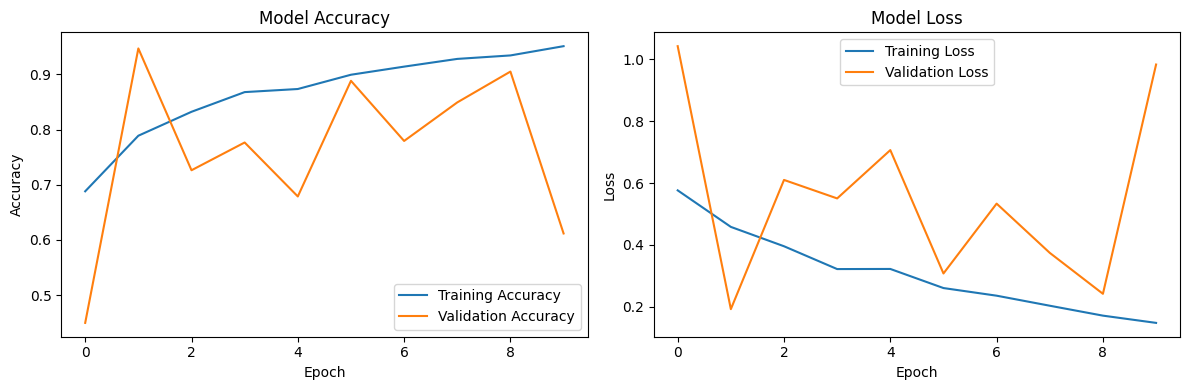

In [20]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()